### Created notebook to avoid the ugly output in the Python console

In [1]:
# %% 0. Set up notebook and import data

# import os
# from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gzip
import warnings
from Bio.Seq import reverse_complement
from Bio.SeqIO.QualityIO import FastqGeneralIterator
from itertools import islice
# import matplotlib.pyplot as plot

# Set  options for testing.
guides_file = "/Users/Claire/Downloads/git_clones/dual_guide_crispr_optimization/parser_files/20200513_library_1_2_unbalanced_dJR051.txt"
r1_file = "/Users/Claire/Downloads/JH8105_1_S1_L001_R1_001.fastq"
r2_file = "/Users/Claire/Downloads/JH8105_1_S1_L001_R2_001.fastq"
N_rows = 1500 # Speed up testing, this just reads the first 10K sequences.
check_length = 500 # top and bottom of the array, how far to check for whether composed with G.
guide_1_offset = -999 # -999 is the sentinel value
guide_2_offset = -999 # -999 is the sentinel value
read_1_offset = -999 # -999 is the sentinel value
read_2_offset = -999 # -999 is the sentinel value
purity = 0.95
check_reverse = True

In [2]:
# %% 1. Run first part of parser script
"""# 1. Import data, this includes concensus guides and R1 + R2 fastqs."""

guides_df = pd.read_csv(guides_file, sep='\t')

with open(r1_file, mode = 'rt') as r1, \
     open(r2_file, mode = 'rt') as r2:
  r1_it = FastqGeneralIterator(r1)
  r2_it = FastqGeneralIterator(r2)

  # Find any failed reads. If 'Y' then the read is bad, otherwise 'N'
  if (N_rows == 0):
    r1_df = pd.DataFrame(r1_it, columns=['title', 'seq', 'qual'])
    r2_df = pd.DataFrame(r2_it, columns=['title', 'seq', 'qual'])
  else:
    # Find any failed reads. If 'Y' then the read is bad, otherwise 'N'
    r1_df = pd.DataFrame(islice(r1_it, 0, N_rows),
                         columns=['title', 'seq', 'qual'])
    r2_df = pd.DataFrame(islice(r2_it, 0, N_rows),
                         columns=['title', 'seq', 'qual'])

# Find any failed reads. If 'Y' then the read is bad, otherwise 'N'
# Get the index of all sequences with at least one unacceptable quality base
# Access 'seq' column in 'r1_df' and check each string to see it contains the character 'N'. Returns bool
removed_r1 = r1_df.seq.str.contains('N')
removed_r2 = r2_df.seq.str.contains('N')

# 'all_removed' contains the failed reads
all_removed = removed_r1 | removed_r2

r1_df = r1_df.loc[~all_removed,:]
r2_df = r2_df.loc[~all_removed,:]

# Check the composition of the guides and the reads. Do they start with G?
# How long are the reads?
guide_1_length = len(guides_df.iloc[0,guides_df.columns.get_loc('protospacer_A')])
guide_2_length = len(guides_df.iloc[0,guides_df.columns.get_loc('protospacer_B')])
original_read_1_length = len(r1_df.iloc[0,r1_df.columns.get_loc('seq')])
original_read_2_length = len(r2_df.iloc[0,r1_df.columns.get_loc('seq')])

assert original_read_1_length >= guide_1_length, 'We must assume read 1 is at least as large as the guide. Otherwise, we did something wrong'
assert original_read_2_length >= guide_2_length, 'We must assume read 2 is at least as large as the guide. Otherwise, we did something wrong'

# Possible output for later, or usage here. The first letter composition of each thing
guide_1_frst_ltrs = guides_df.loc[0:check_length,'protospacer_A'].astype(str).str[0].value_counts()
guide_2_frst_ltrs = guides_df.loc[0:check_length,'protospacer_B'].astype(str).str[0].value_counts()
r1_frst_ltrs = r1_df.loc[0:check_length,'seq'].astype(str).str[0].value_counts()
r2_frst_ltrs = r2_df.loc[0:check_length,'seq'].astype(str).str[0].value_counts()

print("Guide and read truncation readout: ##########")
print(f"Length of input guide 1: {guide_1_length}")
print(f"Length of input guide 2: {guide_2_length}")
print(f"Length of input read 1: {original_read_1_length}")
print(f"Length of input read 2: {original_read_2_length}")

guide_1_end = guide_1_length
guide_2_end = guide_2_length

def get_offset(df, c_length, purity, column, ltr):
  """
  Get the offset based on the inputs.

  Parameters
  df - the dataframe to examine
  c_length - the number of rows to check for the letter
  purity - minimum percentage of reads that start with ltr
  column - the column to look in
  ltr - the starting letter to check for

  Returns
  offset_value - will be either 0 or 1
  """
  first_gs = df.iloc[:c_length, df.columns.get_loc(column)]
  last_gs = df.iloc[-c_length:, df.columns.get_loc(column)]
  # Check whether all rows start with 'G'
  first = sum(first_gs.str.startswith(ltr))
  last = sum(last_gs.str.startswith(ltr))
  if (((first + last) / (2 * c_length)) >= purity):
    offset_value = 1
  else:
    offset_value = 0
  return offset_value

# If the user did not guide_1/read_1 offsets
if guide_1_offset == -999: # -999 is the sentinel value meaning unset
  # If the guide_1 all start with 'G'
  guide_1_offset = get_offset(guides_df, check_length, purity, 'protospacer_A', 'G')
  guide_1_length = (guide_1_end - guide_1_offset)

if guide_2_offset == -999: # -999 is the sentinel value meaning unset
  # If the guide_2 all start with 'G'
  guide_2_offset = get_offset(guides_df, check_length, purity, 'protospacer_B', 'G')
  guide_2_length = guide_2_end - guide_2_offset

if read_1_offset == -999: # -999 is the sentinel value meaning unset
  # If the read_1 all start with 'G'
  read_1_offset = get_offset(r1_df, check_length, purity, 'seq', 'G')

if read_2_offset == -999: # -999 is the sentinel value meaning unset
  # If the read_2 all start with 'G'
  read_2_offset = get_offset(r2_df, check_length, purity, 'seq', 'C')

# Check everything
if read_1_offset + guide_1_length > original_read_1_length:
  raise IndexError("Read 1 not long enough to sustain truncation. " + \
                   "Check input and parameters or manually set offsets.")
if read_2_offset + guide_2_length > original_read_2_length:
  raise IndexError("Read 2 not long enough to sustain truncation " + \
                   "Check input and parameters or manually set offsets.")

read_1_length = guide_1_length
read_1_end = read_1_offset + read_1_length

read_2_length = guide_2_length
read_2_end = read_2_offset + read_2_length

if read_1_end - read_1_offset > guide_1_length:
  raise IndexError(f"After truncation, read 1 length ({str(read_1_length)})" + \
                  f"is too big! guide 1 length ({str(guide_1_length)})!")
if read_2_end - read_2_offset > guide_2_length:
  raise IndexError(f"After truncation, read 2 length ({str(read_2_length)})" + \
                    f"is too big! guide 2 length ({str(guide_2_length)})!")

print(f"Therefore, guide 1 is now {guide_1_length} bp and guide 2 is {guide_2_length} bp")
print(f"guide_1: Going from {guide_1_offset} to {guide_1_end} and guide_2:" + \
      f" from {guide_2_offset} to {guide_2_end}")
print(f"read_1: Going from {read_1_offset} to {read_1_end} and read_2" + \
      f" from {read_2_offset} to {read_2_end}")
print("The reads have been truncated to be the same size as the guides.")

assert read_1_length == guide_1_length, 'Oh no, fix read_1 and g1!'
assert read_2_length == guide_2_length, 'Oh no, fix read_2 and g2!'
assert read_1_end - read_1_offset == read_1_length, 'Oh no, fix read_1 and g2!'
assert read_2_end - read_2_offset == read_2_length, 'Oh no, fix read_2 and g2!'
assert guide_1_length == guide_1_end - guide_1_offset, 'Oh no, fix guide_1!'
assert guide_2_length == guide_2_end - guide_2_offset, 'Oh no, fix guide_2!'

# only do this once
r1_df.insert(loc=2, column='plus', value='+')
r2_df.insert(loc=2, column='plus', value='+')

def split_str(s: str) -> str:
    return s.split(" ", maxsplit = 1)[0]
r1_df['read_group'] = r1_df["title"].apply(split_str)
r2_df['read_group'] = r2_df["title"].apply(split_str)

r1_df['title'] = '@' + r1_df['title']
r2_df['title'] = '@' + r2_df['title']

"""This next code block defines the r1 and r2 keys that are often 19 BP, also making a reverse complement of r2 key."""

# New as of v5.
guides_df['protospacer_A_19bp_trimmed'] = [x[guide_1_offset:guide_1_end] \
                                           for x in guides_df['protospacer_A']]
guides_df['protospacer_B_19bp_trimmed'] = [x[guide_2_offset:guide_2_end] \
                                           for x in guides_df['protospacer_B']]

# Make guide key columns. Ensure all guide sequences are capitalized
guides_df['r1_key'] = guides_df['protospacer_A_19bp_trimmed'].str.upper()

# R2 is tricky as it is the reverse compliment. Flip it and translate using the function below. Ensure all guides sequences are capitalized.
guides_df['r2_key'] = guides_df['protospacer_B_19bp_trimmed'].apply(lambda x: reverse_complement(x).upper())
guides_df['r1_r2_key'] = guides_df['r1_key'] + "_" + guides_df['r2_key']

# Include an option to do the reverse as well
if check_reverse:
  guides_df['r2_r1_key'] = guides_df['protospacer_B_19bp_trimmed'] + "_" + guides_df['protospacer_A_19bp_trimmed'].apply(reverse_complement)

# Get the guide seqs, these relate to the 19 BP segments in the guide_df.
r2_df.loc[:,'guide_seq'] = [x[read_2_offset:read_2_end] for x in r2_df.seq]
r1_df.loc[:,'guide_seq'] = [x[read_1_offset:read_1_end] for x in r1_df.seq]

Guide and read truncation readout: ##########
Length of input guide 1: 20
Length of input guide 2: 20
Length of input read 1: 20
Length of input read 2: 20
Therefore, guide 1 is now 19 bp and guide 2 is 19 bp
guide_1: Going from 1 to 20 and guide_2: from 1 to 20
read_1: Going from 0 to 19 and read_2 from 0 to 19
The reads have been truncated to be the same size as the guides.


In [3]:
# %% 2. Create function to calculate the Hamming Distance. Sequences must be the same length!
# TODO: add filter to to tolerate up to 3 nucleotides difference between the guide library

''' # Option 1
# Function to calculate Hamming distance
# def hamming_distance(seq1, seq2):
#     """
#     Calculate the Hamming distance between two sequences of equal length.
#
#     Parameters:
#     seq1 (str): The first sequence.
#     seq2 (str): The second sequence.
#
#     Returns:
#     int: The Hamming distance between the sequences.
#     """
#     if len(seq1) != len(seq2):
#         raise ValueError("Sequences must be of the same length")
#     return sum(el1 != el2 for el1, el2 in zip(seq1, seq2))
# # Function to calculate the Hamming distance between guide_seq in r1_df and r1_key in guides_df
# def calculate_hamming_distances(r1_df, guides_df):
#     """
#     Calculate the Hamming distance between guide_seq in r1_df and r1_key in guides_df.
#
#     Parameters:
#     r1_df (DataFrame): DataFrame containing the read sequences.
#     guides_df (DataFrame): DataFrame containing the guide sequences.
#
#     Returns:
#     DataFrame: DataFrame with added column 'min_hamming_distance' containing the minimum Hamming distance for each read.
#     """
#     distances = []
#     for r1_seq in r1_df['guide_seq']:
#         min_distance = float(3)
#         for guide_seq in guides_df['r1_key']:
#             try:
#                 distance = hamming_distance(r1_seq, guide_seq)
#                 if distance < min_distance:
#                     min_distance = distance
#             except ValueError:
#                 continue  # Skip sequences of unequal length
#         distances.append("too different")
#     r1_df['min_hamming_distance'] = distances
#     return r1_df
#
# # Calculate Hamming distances
# r1_df = calculate_hamming_distances(r1_df, guides_df)
# print(r1_df[['guide_seq', 'min_hamming_distance']])
# ################################################################
#
# # Option 2
# # Define the hamming_distance function (if not already defined)
# def hamming_distance(seq1, seq2):
#     if len(seq1) != len(seq2):
#         raise ValueError("Sequences must be of the same length")
#     return sum(el1 != el2 for el1, el2 in zip(seq1, seq2))
#
# # Define the function to compare sequences and calculate hamming distances
# def compare_sequences_and_calculate_hamming_distances(r1_df, guides_df):
#     distances = []
#     for r1_seq in r1_df['guide_seq']:
#         min_distance = float('inf')
#         for guide_seq in all_guides:
#             try:
#                 distance = hamming_distance(r1_seq, guide_seq)
#                 if distance < min_distance:
#                     min_distance = distance
#             except ValueError:
#                 continue  # Skip sequences of unequal length
#         distances.append(min_distance)
#     r1_df['min_hamming_distance'] = distances
#     r1_df.sort_values(by='min_hamming_distance', ascending=True)
#     return r1_df
#
# # Apply the function to the DataFrames
# r1_df = compare_sequences_and_calculate_hamming_distances(r1_df, guides_df)
#
# # Display the result
# print(r1_df.sort_values(by='min_hamming_distance', ascending=True))
'''
################################################################
# Option 3
# Define the hamming_distance function
def hamming_distance(seq1, seq2):
    if len(seq1) != len(seq2):
        raise ValueError("Sequences must be of the same length")
    return sum(el1 != el2 for el1, el2 in zip(seq1, seq2))

# Define the function to compare sequences and calculate hamming distances
def compare_sequences_and_generate_df(read_df, guides_df, guide_key):
    """
    Compare the sequences in the guide_seq column of read_df to each element in the r1_key column of guides_df.
    Generate a new DataFrame with guide_seq, r1_key, and their Hamming distances.

    Parameters:
    read_df (DataFrame): DataFrame containing the read sequences.
    guides_df (DataFrame): DataFrame containing the guide sequences.
    guide_key (str): The column name in guides_df containing the guide sequences.


    Returns:
    DataFrame: DataFrame with columns 'guide_seq', 'r1_key', and 'hamming_distance'.
    """
    result_data = []
    for read_seq in read_df['guide_seq']:
        for guide_seq in guides_df[guide_key]:
            try:
                distance = hamming_distance(read_seq, guide_seq)
                result_data.append({'guide_seq': read_seq, guide_key: guide_seq, 'hamming_distance': distance})
            except ValueError:
                continue  # Skip sequences of unequal length
    result_df = pd.DataFrame(result_data).sort_values(by='hamming_distance', ascending=True)
    return result_df


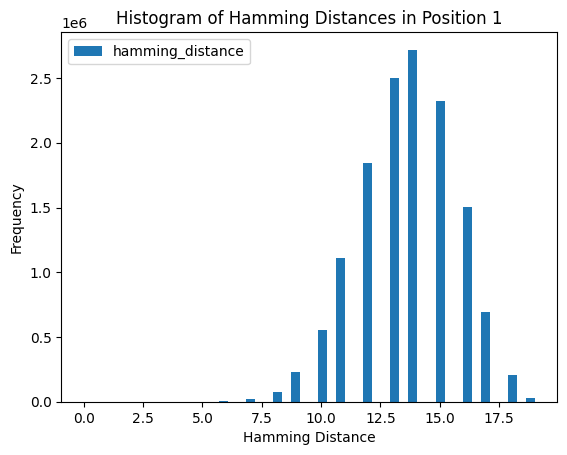

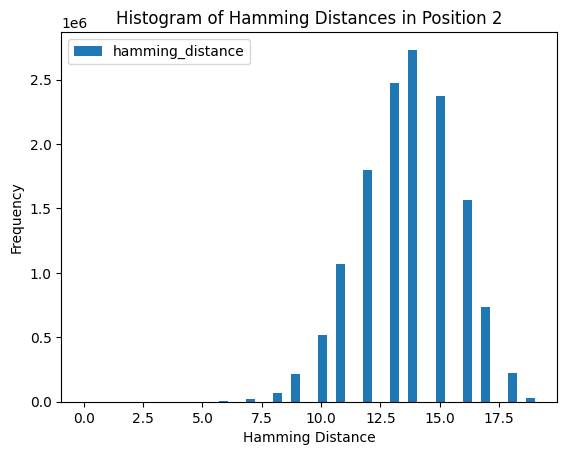

In [4]:
# %% 3. Calculate the Hamming Distances

''' Let's compare the sequenced reads (R1/R2) to the guide seq in positions 1/2, respectively '''

# Apply the function to for guide in position 1
    # Compare 'guide_seq' to 'r1_key'
result_df_r1 = compare_sequences_and_generate_df(r1_df, guides_df, 'r1_key')
# Apply the function to for guide in position 2
    # Compare 'guide_seq' to 'r2_key'
result_df_r2 = compare_sequences_and_generate_df(r2_df, guides_df, 'r2_key')

# Plot histogram of the Hamming distances for Position 1
plt.hist(result_df_r1['hamming_distance'], bins=50, label='hamming_distance')
# Add labels and title
plt.xlabel('Hamming Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Hamming Distances in Position 1')
plt.legend()
# Show plot
plt.show()

# Plot histogram of the Hamming distances for Position 2
plt.hist(result_df_r2['hamming_distance'], bins=50, label='hamming_distance')
# Add labels and title
plt.xlabel('Hamming Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Hamming Distances in Position 2')
plt.legend()
# Show plot
plt.show()

In [9]:
# View table of Hamming distance distribution as table 
result_df_r1.groupby('hamming_distance').size().reset_index(name='n')

,hamming_distance,n
0,0,633
1,1,8
2,2,6
3,3,13
4,4,150
5,5,931
6,6,5082
7,7,22088
8,8,77167
9,9,226269


In [11]:
# View table of Hamming distance distribution as table 
result_df_r2.groupby('hamming_distance').size().reset_index(name='n')

,hamming_distance,n
0,0,623
1,1,16
2,2,4
3,3,7
4,4,113
5,5,834
6,6,4469
7,7,19615
8,8,70318
9,9,211408


In [ ]:
# %% 4. Print summary tables of Hamming distances
# View values with a Hamming distance between 1-3
# # Select the 'hamming_distance' column and filter rows between 1 and 3
# sm_ham_dist_posit_1 = result_df_r1[(result_df_r1['hamming_distance'] <= 3) & (result_df_r1['hamming_distance'] >= 1)]
# sm_ham_dist_posit_2 = result_df_r2[(result_df_r2['hamming_distance'] <= 3) & (result_df_r2['hamming_distance'] >= 1)]

# Filter read_df to keep only rows with hamming_distance < 3 and hamming_distance > 1
r1_filtered = result_df_r1[(result_df_r1['hamming_distance'] <= 3) & (result_df_r1['hamming_distance'] >= 1)]
r2_filtered = result_df_r2[(result_df_r2['hamming_distance'] <= 3) & (result_df_r2['hamming_distance'] >= 1)]

# 'r#_filtered' dataframes contain only 1 <= Hamming distance <= 3 for their respective reads.
# Merge filtered_df with guides_df on the read_key column'
r1_filtered = pd.merge(r1_filtered, guides_df, on='r1_key', how='inner')
r2_filtered = pd.merge(r2_filtered, guides_df, on='r2_key', how='inner')

# Reorder columns for easy viewing
r1_filtered = r1_filtered[['guide_seq', 'r1_key', 'hamming_distance', 'gene', 'sgID_A', 'sgID_B', 'protospacer_A', 'protospacer_B', 'protospacer_A_19bp_trimmed', 'protospacer_B_19bp_trimmed', 'r2_key', 'r1_r2_key', 'r2_r1_key']]
r2_filtered = r2_filtered[['guide_seq', 'r2_key', 'hamming_distance', 'gene', 'sgID_A', 'sgID_B', 'protospacer_A', 'protospacer_B', 'protospacer_A_19bp_trimmed', 'protospacer_B_19bp_trimmed', 'r1_key', 'r1_r2_key', 'r2_r1_key']]

# Calculate the percentage of guides that differ by 1-3 nucleotides
r1_pct_filtered = round((len(r1_filtered)/len(r1_df))*100, 3)
r2_pct_filtered = round((len(r2_filtered)/len(r2_df))*100, 3)

# Print summary statements about the Hamming Distances
print(f'{len(r1_filtered)} gRNAs out of {len(r1_df)} total gRNAs in R2 have a Hamming distance between 1-3 which is {r1_pct_filtered}% of the total guides from R2')
print(f'{len(r2_filtered)} gRNAs out of {len(r2_df)} total gRNAs in R2 have a Hamming distance between 1-3 which is {r2_pct_filtered}% of the total guides from R2')
